## Import libraries

In [1]:
! pip install impyute

In [2]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from impyute.imputation.cs import mice
from sklearn.preprocessing import QuantileTransformer

## Load source datasets

In [3]:
train_df = pd.read_csv("../input/he-fast-furious-insured/dataset/train.csv")
test_df = pd.read_csv("../input/he-fast-furious-insured/dataset/test.csv")
train_df.shape, test_df.shape

((1399, 8), (600, 6))

## Data Cleansing

In [4]:
train_df = train_df[~((train_df['Amount'].isnull()) | (train_df['Amount'] < 0) | (train_df['Amount'] > 11000))].copy()
train_df = train_df[(train_df['Cost_of_vehicle'].isnull())|(np.log1p(train_df['Cost_of_vehicle']) > 9.8)].copy()

test_df['Condition'] = 1
test_df.loc[test_df['Max_coverage'] > 14000, 'Condition'] = 0

image_train_df = train_df.copy()
image_test_df = test_df.copy()

train_df.shape, test_df.shape

((1382, 8), (600, 7))

In [5]:
test_df.groupby(['Condition']).size().reset_index().rename(columns={0:'count'})

,Condition,count
0,0,43
1,1,557


## Pre-process non-numeric features

In [6]:
train_df['Parent_company'] = train_df['Insurance_company'].apply(lambda x: x if len(x)<2 else x[0])
test_df['Parent_company'] = test_df['Insurance_company'].apply(lambda x: x if len(x)<2 else x[0])

company_map = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'O': 4,
    'R': 5,
}

train_df['Parent_company'] = train_df['Parent_company'].map(company_map)
test_df['Parent_company'] = test_df['Parent_company'].map(company_map)
train_df.groupby(['Parent_company']).size().reset_index().rename(columns={0:'count'})

,Parent_company,count
0,0,370
1,1,514
2,2,131
3,3,128
4,4,124
5,5,115


In [7]:
train_df['Child_company'] = train_df['Insurance_company'].apply(lambda x: 'X' if len(x)<2 else x[1])
test_df['Child_company'] = test_df['Insurance_company'].apply(lambda x: 'X' if len(x)<2 else x[1])

company_map = {
    'A': 0,
    'B': 1,
    'C': 2,
    'E': 3,
    'Q': 4,
    'X': 5,
}

train_df['Child_company'] = train_df['Child_company'].map(company_map)
test_df['Child_company'] = test_df['Child_company'].map(company_map)
train_df.groupby(['Child_company']).size().reset_index().rename(columns={0:'count'})

,Child_company,count
0,0,248
1,1,123
2,2,237
3,3,115
4,4,129
5,5,530


In [8]:
company_map = {
    'A': 0,
    'AA': 1,
    'AC': 2,
    'B': 3,
    'BB': 4,
    'BC': 5,
    'BQ': 6,
    'C': 7,
    'DA': 8,
    'O': 9,
    'RE': 10,
}

train_df['Insurance_company'] = train_df['Insurance_company'].map(company_map)
test_df['Insurance_company'] = test_df['Insurance_company'].map(company_map)
train_df.groupby(['Insurance_company']).size().reset_index().rename(columns={0:'count'})

,Insurance_company,count
0,0,132
1,1,120
2,2,118
3,3,143
4,4,123
5,5,119
6,6,129
7,7,131
8,8,128
9,9,124


In [9]:
train_df['expiry_dt_year'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).year)
train_df['expiry_dt_quarter'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).quarter)
train_df['expiry_dt_month'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).month)
train_df['expiry_dt_week'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).week)
train_df['expiry_dt_day_year'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).dayofyear)
train_df['expiry_dt_day_month'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).day)
train_df['expiry_dt_day_week'] = train_df['Expiry_date'].map(lambda x: pd.to_datetime(x).dayofweek)
train_df['expiry_dt_day_weekend'] = np.where(train_df['expiry_dt_day_week'].isin([5,6]),1,0)

test_df['expiry_dt_year'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).year)
test_df['expiry_dt_quarter'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).quarter)
test_df['expiry_dt_month'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).month)
test_df['expiry_dt_week'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).week)
test_df['expiry_dt_day_year'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).dayofyear)
test_df['expiry_dt_day_month'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).day)
test_df['expiry_dt_day_week'] = test_df['Expiry_date'].map(lambda x: pd.to_datetime(x).dayofweek)
test_df['expiry_dt_day_weekend'] = np.where(test_df['expiry_dt_day_week'].isin([5,6]),1,0)

train_df.drop(['Expiry_date','Image_path','Amount'], axis=1, inplace=True)
test_df.drop(['Expiry_date','Image_path'], axis=1, inplace=True)
train_df.head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,expiry_dt_day_year,expiry_dt_day_month,expiry_dt_day_week,expiry_dt_day_weekend
0,6,41500.0,1037.5,36142.68,0,1,4,2026,4,12,49,337,3,3,0
1,6,50700.0,1267.5,12753.00,1,1,4,2025,3,7,28,191,10,3,0
2,0,49500.0,1237.5,43102.68,0,0,5,2022,3,8,32,223,11,3,0
3,0,33500.0,837.5,8453.00,1,0,5,2022,3,8,31,214,2,1,0
4,2,27600.0,690.0,6978.00,1,0,2,2026,2,5,18,121,1,4,0


## Missing values imputation

In [10]:
train_df = pd.DataFrame(mice(train_df.values), columns=train_df.columns, index=train_df.index)
train_df.head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,expiry_dt_day_year,expiry_dt_day_month,expiry_dt_day_week,expiry_dt_day_weekend
0,6.0,41500.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,337.0,3.0,3.0,0.0
1,6.0,50700.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,191.0,10.0,3.0,0.0
2,0.0,49500.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,223.0,11.0,3.0,0.0
3,0.0,33500.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,214.0,2.0,1.0,0.0
4,2.0,27600.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,121.0,1.0,4.0,0.0


In [11]:
train_df[train_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,expiry_dt_day_year,expiry_dt_day_month,expiry_dt_day_week,expiry_dt_day_weekend


In [12]:
test_df[test_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,expiry_dt_day_year,expiry_dt_day_month,expiry_dt_day_week,expiry_dt_day_weekend


## Feature Engineering

In [13]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df['ID'] = combined_df.reset_index().index
combined_df.head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,expiry_dt_day_year,expiry_dt_day_month,expiry_dt_day_week,expiry_dt_day_weekend,ID
0,6.0,41500.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,337.0,3.0,3.0,0.0,0
1,6.0,50700.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,191.0,10.0,3.0,0.0,1
2,0.0,49500.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,223.0,11.0,3.0,0.0,2
3,0.0,33500.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,214.0,2.0,1.0,0.0,3
4,2.0,27600.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,121.0,1.0,4.0,0.0,4


In [14]:
combined_df['Mean_coverage'] = (combined_df['Min_coverage'] + combined_df['Max_coverage'])/2
combined_df['Coverage_ratio'] = combined_df['Min_coverage'] / combined_df['Max_coverage']
combined_df['Min/Mean_coverage'] = combined_df['Min_coverage'] / combined_df['Mean_coverage']
combined_df['Max/Mean_coverage'] = combined_df['Max_coverage'] / combined_df['Mean_coverage']
combined_df['CoV/Mean_coverage'] = combined_df['Cost_of_vehicle'] / combined_df['Mean_coverage']
combined_df['CoV*Cov_ratio'] = combined_df['Cost_of_vehicle'] * combined_df['Coverage_ratio']
combined_df.drop(['Cost_of_vehicle'], axis=1, inplace=True)

In [15]:
fet_engg_dict = {
    'Min_coverage': ['sum', 'mean', 'std'],
    'Max_coverage': ['sum', 'mean', 'std'],
    'Mean_coverage': ['sum', 'mean', 'std'],
}

In [16]:
temp = combined_df.groupby(['Insurance_company']).agg(fet_engg_dict)
temp.columns = ['IC_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['Insurance_company'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,CoV*Cov_ratio,IC_Min_coverage_sum,IC_Min_coverage_mean,IC_Min_coverage_std,IC_Max_coverage_sum,IC_Max_coverage_mean,IC_Max_coverage_std,IC_Mean_coverage_sum,IC_Mean_coverage_mean,IC_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,1191.285483,172582.515432,953.494560,228.677843,2.137409e+06,11808.889974,7887.130256,1.154996e+06,6381.192267,3991.783598
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,5038.990826,172582.515432,953.494560,228.677843,2.137409e+06,11808.889974,7887.130256,1.154996e+06,6381.192267,3991.783598
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,1421.170331,183511.886574,955.791076,213.252080,2.193114e+06,11422.467968,7198.094556,1.188313e+06,6189.129522,3644.306279
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3319.087898,183511.886574,955.791076,213.252080,2.193114e+06,11422.467968,7198.094556,1.188313e+06,6189.129522,3644.306279
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,2729.148753,160365.329861,954.555535,240.526803,1.802454e+06,10728.891963,5847.040550,9.814096e+05,5841.723749,2981.396272


In [17]:
temp = combined_df.groupby(['Parent_company']).agg(fet_engg_dict)
temp.columns = ['PC_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['Parent_company'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,IC_Mean_coverage_std,PC_Min_coverage_sum,PC_Min_coverage_mean,PC_Min_coverage_std,PC_Max_coverage_sum,PC_Max_coverage_mean,PC_Max_coverage_std,PC_Mean_coverage_sum,PC_Mean_coverage_mean,PC_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3991.783598,693095.046296,942.986458,222.729126,8.260081e+06,11238.205893,6876.335740,4.476588e+06,6090.596175,3483.633905
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3991.783598,693095.046296,942.986458,222.729126,8.260081e+06,11238.205893,6876.335740,4.476588e+06,6090.596175,3483.633905
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3644.306279,511272.231867,943.306701,223.465975,6.085953e+06,11228.695088,7071.534743,3.298612e+06,6086.000894,3584.832214
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3644.306279,511272.231867,943.306701,223.465975,6.085953e+06,11228.695088,7071.534743,3.298612e+06,6086.000894,3584.832214
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,2981.396272,511272.231867,943.306701,223.465975,6.085953e+06,11228.695088,7071.534743,3.298612e+06,6086.000894,3584.832214


In [18]:
temp = combined_df.groupby(['Child_company']).agg(fet_engg_dict)
temp.columns = ['CC_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['Child_company'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,PC_Mean_coverage_std,CC_Min_coverage_sum,CC_Min_coverage_mean,CC_Min_coverage_std,CC_Max_coverage_sum,CC_Max_coverage_mean,CC_Max_coverage_std,CC_Mean_coverage_sum,CC_Mean_coverage_mean,CC_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3483.633905,172582.515432,953.494560,228.677843,2.137409e+06,11808.889974,7887.130256,1.154996e+06,6381.192267,3991.783598
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3483.633905,172582.515432,953.494560,228.677843,2.137409e+06,11808.889974,7887.130256,1.154996e+06,6381.192267,3991.783598
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3584.832214,715343.804012,942.481955,215.917714,8.456635e+06,11141.811470,6914.770601,4.585989e+06,6042.146713,3504.655571
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3584.832214,715343.804012,942.481955,215.917714,8.456635e+06,11141.811470,6914.770601,4.585989e+06,6042.146713,3504.655571
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,3584.832214,315096.587577,954.838144,237.087064,3.636909e+06,11020.937427,6509.068680,1.976003e+06,5987.887786,3309.119981


In [19]:
temp = combined_df.groupby(['expiry_dt_year']).agg(fet_engg_dict)
temp.columns = ['YR_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['expiry_dt_year'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,CC_Mean_coverage_std,YR_Min_coverage_sum,YR_Min_coverage_mean,YR_Min_coverage_std,YR_Max_coverage_sum,YR_Max_coverage_mean,YR_Max_coverage_std,YR_Mean_coverage_sum,YR_Mean_coverage_mean,YR_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3991.783598,256570.329861,929.602644,208.941649,3.102885e+06,11242.336956,7315.634425,1.679728e+06,6085.969800,3703.229191
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3991.783598,239036.902006,941.090165,224.949347,2.851960e+06,11228.188598,6873.839519,1.545498e+06,6084.639382,3482.620065
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3504.655571,282032.530864,952.812604,218.892555,3.410079e+06,11520.536962,7465.874050,1.846056e+06,6236.674783,3780.240939
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3504.655571,282032.530864,952.812604,218.892555,3.410079e+06,11520.536962,7465.874050,1.846056e+06,6236.674783,3780.240939
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,3309.119981,256570.329861,929.602644,208.941649,3.102885e+06,11242.336956,7315.634425,1.679728e+06,6085.969800,3703.229191


In [20]:
temp = combined_df.groupby(['expiry_dt_quarter']).agg(fet_engg_dict)
temp.columns = ['QTR_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['expiry_dt_quarter'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,YR_Mean_coverage_std,QTR_Min_coverage_sum,QTR_Min_coverage_mean,QTR_Min_coverage_std,QTR_Max_coverage_sum,QTR_Max_coverage_mean,QTR_Max_coverage_std,QTR_Mean_coverage_sum,QTR_Mean_coverage_mean,QTR_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3703.229191,530658.175154,947.603884,221.225124,6.274020e+06,11203.608002,6813.472052,3.402339e+06,6075.605943,3452.942545
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3482.620065,441173.474151,930.745726,218.099477,5.205556e+06,10982.186494,6583.042711,2.823365e+06,5956.466110,3336.338629
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3780.240939,441173.474151,930.745726,218.099477,5.205556e+06,10982.186494,6583.042711,2.823365e+06,5956.466110,3336.338629
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3780.240939,441173.474151,930.745726,218.099477,5.205556e+06,10982.186494,6583.042711,2.823365e+06,5956.466110,3336.338629
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,3703.229191,453704.731867,931.631893,220.782815,5.351019e+06,10987.718609,6752.816347,2.902362e+06,5959.675251,3424.715898


In [21]:
temp = combined_df.groupby(['expiry_dt_month']).agg(fet_engg_dict)
temp.columns = ['MNTH_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['expiry_dt_month'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,QTR_Mean_coverage_std,MNTH_Min_coverage_sum,MNTH_Min_coverage_mean,MNTH_Min_coverage_std,MNTH_Max_coverage_sum,MNTH_Max_coverage_mean,MNTH_Max_coverage_std,MNTH_Mean_coverage_sum,MNTH_Mean_coverage_mean,MNTH_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3452.942545,211630.644290,961.957474,235.022080,2.466064e+06,11209.381247,6884.375452,1.338847e+06,6085.669361,3496.559279
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3336.338629,159253.443287,925.892112,223.541972,1.899534e+06,11043.803511,6771.310805,1.029394e+06,5984.847812,3431.374576
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3336.338629,142563.773148,937.919560,217.259792,1.729011e+06,11375.073697,7823.501512,9.357875e+05,6156.496629,3964.924077
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3336.338629,142563.773148,937.919560,217.259792,1.729011e+06,11375.073697,7823.501512,9.357875e+05,6156.496629,3964.924077
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,3424.715898,156751.886574,927.525956,223.187234,1.882070e+06,11136.510700,6844.251891,1.019411e+06,6032.018328,3466.473815


In [22]:
temp = combined_df.groupby(['expiry_dt_day_week']).agg(fet_engg_dict)
temp.columns = ['WK_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['expiry_dt_day_week'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,MNTH_Mean_coverage_std,WK_Min_coverage_sum,WK_Min_coverage_mean,WK_Min_coverage_std,WK_Max_coverage_sum,WK_Max_coverage_mean,WK_Max_coverage_std,WK_Mean_coverage_sum,WK_Mean_coverage_mean,WK_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3496.559279,286482.530864,936.217421,216.005593,3.373106e+06,11023.222611,6786.597219,1.829794e+06,5979.720016,3440.805033
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3431.374576,286482.530864,936.217421,216.005593,3.373106e+06,11023.222611,6786.597219,1.829794e+06,5979.720016,3440.805033
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3964.924077,286482.530864,936.217421,216.005593,3.373106e+06,11023.222611,6786.597219,1.829794e+06,5979.720016,3440.805033
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3964.924077,278615.329861,938.098754,214.366461,3.213066e+06,10818.404856,5984.426271,1.745841e+06,5878.251805,3034.766617
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,3466.473815,268627.515432,962.822636,224.419032,3.333133e+06,11946.714310,7974.471345,1.800880e+06,6454.768473,4034.192475


In [23]:
temp = combined_df.groupby(['expiry_dt_day_weekend']).agg(fet_engg_dict)
temp.columns = ['WKND_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['expiry_dt_day_weekend'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,WK_Mean_coverage_std,WKND_Min_coverage_sum,WKND_Min_coverage_mean,WKND_Min_coverage_std,WKND_Max_coverage_sum,WKND_Max_coverage_mean,WKND_Max_coverage_std,WKND_Mean_coverage_sum,WKND_Mean_coverage_mean,WKND_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3440.805033,1.356554e+06,945.993141,218.92755,1.614433e+07,11258.252765,6915.418696,8.750444e+06,6102.122953,3502.909705
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3440.805033,1.356554e+06,945.993141,218.92755,1.614433e+07,11258.252765,6915.418696,8.750444e+06,6102.122953,3502.909705
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3440.805033,1.356554e+06,945.993141,218.92755,1.614433e+07,11258.252765,6915.418696,8.750444e+06,6102.122953,3502.909705
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3034.766617,1.356554e+06,945.993141,218.92755,1.614433e+07,11258.252765,6915.418696,8.750444e+06,6102.122953,3502.909705
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,4034.192475,1.356554e+06,945.993141,218.92755,1.614433e+07,11258.252765,6915.418696,8.750444e+06,6102.122953,3502.909705


In [24]:
temp = combined_df.groupby(['Condition']).agg(fet_engg_dict)
temp.columns = ['Condition_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df,temp,on=['Condition'],how='left')
combined_df.head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,WKND_Mean_coverage_std,Condition_Min_coverage_sum,Condition_Min_coverage_mean,Condition_Min_coverage_std,Condition_Max_coverage_sum,Condition_Max_coverage_mean,Condition_Max_coverage_std,Condition_Mean_coverage_sum,Condition_Mean_coverage_mean,Condition_Mean_coverage_std
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,3502.909705,1.393781e+05,981.536119,240.147235,4.808760e+06,33864.505679,7911.578322,2.474069e+06,17423.020899,4061.047951
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,3502.909705,1.729314e+06,939.844517,217.575342,1.743821e+07,9477.285756,2175.846965,9.583760e+06,5208.565137,1196.706545
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,3502.909705,1.393781e+05,981.536119,240.147235,4.808760e+06,33864.505679,7911.578322,2.474069e+06,17423.020899,4061.047951
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,3502.909705,1.729314e+06,939.844517,217.575342,1.743821e+07,9477.285756,2175.846965,9.583760e+06,5208.565137,1196.706545
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,3502.909705,1.729314e+06,939.844517,217.575342,1.743821e+07,9477.285756,2175.846965,9.583760e+06,5208.565137,1196.706545


In [25]:
combined_df[combined_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,WKND_Mean_coverage_std,Condition_Min_coverage_sum,Condition_Min_coverage_mean,Condition_Min_coverage_std,Condition_Max_coverage_sum,Condition_Max_coverage_mean,Condition_Max_coverage_std,Condition_Mean_coverage_sum,Condition_Mean_coverage_mean,Condition_Mean_coverage_std


In [26]:
train_df = combined_df[:image_train_df.shape[0]].copy()
test_df = combined_df[image_train_df.shape[0]:].copy()

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
train_df['Amount'] = image_train_df['Amount'].values

train_df.shape, test_df.shape

((1382, 103), (600, 102))

## Frequency Encoding and Mean Target Encoding

In [27]:
cat_cols = ['Insurance_company','Parent_company','Child_company','expiry_dt_year','expiry_dt_quarter',
            'expiry_dt_month','expiry_dt_day_week','expiry_dt_day_weekend','Condition']

In [28]:
for variable in tqdm(cat_cols):
    count_dict = train_df.groupby([variable]).size()/len(train_df)
    train_df[variable+'_fe'] = train_df[variable].map(count_dict)
    test_df[variable+'_fe'] = test_df[variable].map(count_dict)
    
train_df.head()

100%|██████████| 9/9 [00:00<00:00, 373.29it/s]


,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,Amount,Insurance_company_fe,Parent_company_fe,Child_company_fe,expiry_dt_year_fe,expiry_dt_quarter_fe,expiry_dt_month_fe,expiry_dt_day_week_fe,expiry_dt_day_weekend_fe,Condition_fe
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,0.0,0.093343,0.371925,0.093343,0.138929,0.287265,0.115051,0.161360,0.727931,0.071635
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,6194.0,0.093343,0.371925,0.093343,0.122287,0.229378,0.085384,0.161360,0.727931,0.928365
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,0.0,0.095514,0.267728,0.383502,0.150507,0.229378,0.071635,0.161360,0.727931,0.071635
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,7699.0,0.095514,0.267728,0.383502,0.150507,0.229378,0.071635,0.146165,0.727931,0.928365
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,8849.0,0.085384,0.267728,0.171491,0.138929,0.245297,0.080318,0.140376,0.727931,0.928365


In [29]:
for variable in tqdm(cat_cols):
    mte_dict = train_df.groupby([variable])['Amount'].mean().to_dict()
    train_df[variable+'_mte'] = train_df[variable].map(mte_dict)
    test_df[variable+'_mte'] = test_df[variable].map(mte_dict)

train_df.head()

100%|██████████| 9/9 [00:00<00:00, 354.54it/s]


,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,Condition_fe,Insurance_company_mte,Parent_company_mte,Child_company_mte,expiry_dt_year_mte,expiry_dt_quarter_mte,expiry_dt_month_mte,expiry_dt_day_week_mte,expiry_dt_day_weekend_mte,Condition_mte
0,6.0,1037.5,36142.68,0.0,1.0,4.0,2026.0,4.0,12.0,49.0,...,0.071635,4135.891473,4101.492218,4135.891473,4440.010417,4225.181360,3893.100629,3817.224215,4056.270378,0.000000
1,6.0,1267.5,12753.00,1.0,1.0,4.0,2025.0,3.0,7.0,28.0,...,0.928365,4135.891473,4101.492218,4135.891473,4018.455621,4049.482650,3821.466102,3817.224215,4056.270378,4375.268122
2,0.0,1237.5,43102.68,0.0,0.0,5.0,2022.0,3.0,8.0,32.0,...,0.071635,4284.962121,4081.613514,4040.698113,4073.091346,4049.482650,4463.090909,3817.224215,4056.270378,0.000000
3,0.0,837.5,8453.00,1.0,0.0,5.0,2022.0,3.0,8.0,31.0,...,0.928365,4284.962121,4081.613514,4040.698113,4073.091346,4049.482650,4463.090909,4134.445545,4056.270378,4375.268122
4,2.0,690.0,6978.00,1.0,0.0,2.0,2026.0,2.0,5.0,18.0,...,0.928365,3950.559322,4081.613514,4045.426160,4440.010417,4080.294985,3808.576577,4011.706186,4056.270378,4375.268122


## Quantile Transformation

In [30]:
num_cols = [col for col in train_df.loc[:, train_df.columns != 'Amount'].columns if col not in cat_cols]
len(cat_cols), len(num_cols)

(9, 111)

In [31]:
for col in tqdm(num_cols):
    transformer = QuantileTransformer(n_quantiles=1000, 
                                      random_state=10, 
                                      output_distribution="normal")
    
    vec_len = len(train_df[col].values)
    vec_len_test = len(test_df[col].values)

    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

100%|██████████| 111/111 [00:00<00:00, 163.14it/s]


In [32]:
for col in tqdm(cat_cols):
    transformer = QuantileTransformer(n_quantiles=1000, 
                                      random_state=10, 
                                      output_distribution="uniform")
    
    vec_len = len(train_df[col].values)
    vec_len_test = len(test_df[col].values)

    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

100%|██████████| 9/9 [00:00<00:00, 222.08it/s]


## PCA Features

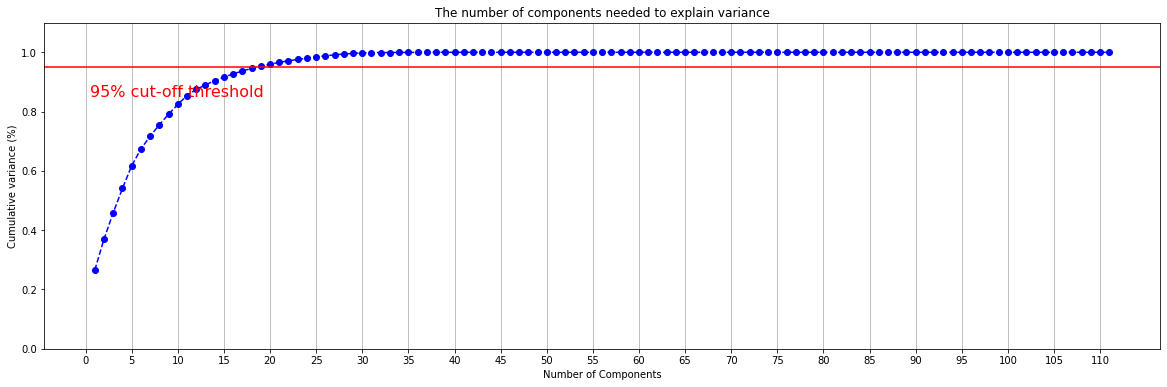

In [33]:
# Deciding n_components for PCA
data = pd.concat([train_df[num_cols], test_df[num_cols]], axis=0)
pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots()
xi = np.arange(1, 112, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 111, step=5))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [34]:
def pca_fet(train, test, features, n_components, SEED=10):
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    index = data.index

    pca = PCA(n_components=n_components, random_state=SEED)
    data = pca.fit_transform(data)
    columns = [f'pca_{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns=columns, index=index)
    
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:]
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [35]:
train_df, test_df = pca_fet(train_df, test_df, num_cols, n_components=20)
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (1382, 141) 
test_df: (600, 140)


## KMeans Features

In [36]:
def kmeans_fet(train, test, features, n_clusters, SEED=10):
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(data)
    
    train[f'clusters_'] = kmeans.labels_[:train.shape[0]]
    test[f'clusters_'] = kmeans.labels_[train.shape[0]:]
    train = pd.get_dummies(train, columns = [f'clusters_'])
    test = pd.get_dummies(test, columns = [f'clusters_'])
    return train, test

In [37]:
train_df, test_df = kmeans_fet(train_df, test_df, [col for col in train_df.columns if col!='Amount'], n_clusters=15)
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (1382, 156) 
test_df: (600, 155)


In [38]:
train_df['Image_path'] = image_train_df['Image_path'].values
test_df['Image_path'] = image_test_df['Image_path'].values

train_df['Image_path'] = train_df['Image_path'].apply(lambda x: "../input/he-fast-furious-insured/dataset/trainImages/" + x)
test_df['Image_path'] = test_df['Image_path'].apply(lambda x: "../input/he-fast-furious-insured/dataset/testImages/" + x)
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df.head()

train_df: (1382, 157) 
test_df: (600, 156)


,Insurance_company,Min_coverage,Max_coverage,Condition,Parent_company,Child_company,expiry_dt_year,expiry_dt_quarter,expiry_dt_month,expiry_dt_week,...,clusters__6,clusters__7,clusters__8,clusters__9,clusters__10,clusters__11,clusters__12,clusters__13,clusters__14,Image_path
0,0.593093,0.411534,1.895378,0.0,0.453453,0.570070,0.642142,1.000000,1.000000,1.318946,...,0,0,0,0,0,0,0,0,0,../input/he-fast-furious-insured/dataset/train...
1,0.593093,1.464186,1.104747,1.0,0.453453,0.570070,0.511011,0.598098,0.526026,0.040157,...,0,0,0,0,0,0,0,0,0,../input/he-fast-furious-insured/dataset/train...
2,0.000000,1.212751,2.225731,0.0,0.000000,1.000000,0.101101,0.598098,0.604605,0.216204,...,0,0,0,0,0,0,0,0,0,../input/he-fast-furious-insured/dataset/train...
3,0.000000,-0.369558,-0.425228,1.0,0.000000,1.000000,0.101101,0.598098,0.604605,0.177827,...,0,0,0,0,0,0,0,0,0,../input/he-fast-furious-insured/dataset/train...
4,0.224725,-0.989697,-1.029375,1.0,0.000000,0.354354,0.642142,0.360360,0.358358,-0.461215,...,0,0,0,0,0,0,0,1,0,../input/he-fast-furious-insured/dataset/train...


## Save processed datasets

In [39]:
data_dict = {}
data_dict['train_df'] = train_df
data_dict['test_df'] = test_df

file = open("./HE_FFI_Dataset.txt", 'wb')
pickle.dump(data_dict, file)
file.close()